# Ordinary Least Squares (OLS) Regression - Newton Rhapson
#### by Andrew Rothman

Here we will explore Ordinary Least Squares (OLS) Regression in closed from where we will: <br>
* Specify the statistical model and it's functional form
* Using the Iris dataset as a motivating example, we will recover estimates of the parameters of the model we specified

## 1) Model Specification
### Variables & Dimensions
Let us begin by specifying our variable relations and matrix dimensions:

$$
\begin{align}
Y = X \beta + \epsilon \\
Y = X \hat{\beta} + e \\
\hat{Y} = X\hat{\beta} \\
\end{align}
$$

$\begin{aligned}
n=
\end{aligned}$ number of observations

$\begin{aligned}
p=
\end{aligned}$ number of parameters

Note, that in this formulation we are imbedding the intercept term into the Design and Parameter matrices

$$
\begin{align}
Y : n\times 1 \\
X : n\times (p+1) \\
\beta : (p+1)\times 1 \\
\epsilon, e : n\times 1
\end{align}
$$

### Cost Function (Residual Sum of Squares)

$$
\begin{align}
RSS = e^{T}e^{} \\
= (Y - X \hat{\beta})^{T}(Y - X \hat{\beta}) \\
= (Y^{T} - \hat{\beta}^{T}X^{T})(Y - X \hat{\beta}) \\
= Y^{T}Y -Y^{T}X\hat{\beta} - \hat{\beta}^{T}X^{T}Y + \hat{\beta}^{T}X^{T}X\hat{\beta} \\
= Y^{T}Y - 2\hat{\beta}^{T}X^{T}Y + \hat{\beta}^{T}X^{T}X\hat{\beta} \\
\end{align}
$$

### First and Second Partial Derivatives (with respect to Beta)

$$
\begin{align}
\frac{\partial RSS}{\partial \hat{\beta}} = -2X^{T}Y + 2X^{T}X \hat{\beta} \\
\frac{\partial^{2} RSS}{\partial^{2} \hat{\beta}} = 2X^{T}X \\
\end{align}
$$

### Newton Rhapson Algorithm

$$
\begin{align}
\frac{\partial RSS}{\partial \hat{\beta}} = -2X^{T}Y + 2X^{T}X \hat{\beta} &\stackrel{set}{=} 0 \\
\frac{\partial^{2} RSS}{\partial^{2} \hat{\beta}} = 2X^{T}X \\
\\
\hat{\beta}_{i+1} = \hat{\beta}_i - \frac{\frac{\partial RSS}{\partial \hat{\beta}_i}}{\frac{\partial^{2} RSS}{\partial^{2} \hat{\beta}_i}} = \hat{\beta}_i - (\frac{\partial^{2} RSS}{\partial^{2} \hat{\beta}_i})^{-1}\frac{\partial RSS}{\partial \hat{\beta}_i}  \\
\end{align}
$$

## 2) Motivating Example with the "Iris" Dataset
We will show the above closed form solution in action with a motivating example. We will use the Iris Dataset to do so by:
* Using "Sepal Length" as our outcome of interest, with all remaining variables as covariates in the regression model
 * Note, the variable "Species" is reparameterized as "one-hot" coding, with the category "virginica" set as the reference category

In [13]:
######################
## import libraries ##
######################
import numpy as np
import pandas as pd
from sklearn import datasets
import statsmodels.formula.api as sm
from numpy.linalg import inv
import matplotlib.pyplot as plt 

In [14]:
###################################
## import and clean iris dataset ##
###################################
iris = datasets.load_iris()
df = pd.DataFrame()
df['S_Length'] = iris['data'][:,0]
df['Intercept']=np.full(iris['data'].shape[0], 1)
df['S_Width'] = iris['data'][:,1]
df['P_Length'] = iris['data'][:,2]
df['P_Width'] = iris['data'][:,3]
df['Species'] = iris['target']
df['Species'] = df['Species'].apply(str)
df.loc[df['Species']==str(0), "Species"] = str(iris['target_names'][0])
df.loc[df['Species']==str(1), "Species"] = str(iris['target_names'][1])
df.loc[df['Species']==str(2), "Species"] = str(iris['target_names'][2])
df['Species_setosa']=0
df.loc[df['Species']=='setosa', 'Species_setosa']=1
df['Species_versicolor']=0
df.loc[df['Species']=='versicolor', 'Species_versicolor']=1
df = df.drop('Species', axis=1)
df.describe()

,S_Length,Intercept,S_Width,P_Length,P_Width,Species_setosa,Species_versicolor
count,150.000000,150.0,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,1.0,3.054000,3.758667,1.198667,0.333333,0.333333
std,0.828066,0.0,0.433594,1.764420,0.763161,0.472984,0.472984
min,4.300000,1.0,2.000000,1.000000,0.100000,0.000000,0.000000
25%,5.100000,1.0,2.800000,1.600000,0.300000,0.000000,0.000000
50%,5.800000,1.0,3.000000,4.350000,1.300000,0.000000,0.000000
75%,6.400000,1.0,3.300000,5.100000,1.800000,1.000000,1.000000
max,7.900000,1.0,4.400000,6.900000,2.500000,1.000000,1.000000


In [15]:
## creat arrays for closed form solution
Y = np.array(df['S_Length']).reshape((len(df['S_Length']), 1))
X = np.array(df[['Intercept', 'S_Width', 'P_Length', 'P_Width', 'Species_setosa', 'Species_versicolor']])

## 3) Compute Solution

In [16]:
#################################
## initialize parameter matrix ##
#################################
k = X.shape[1]
np.random.seed(10815657)
nudge=0.01
Beta = np.random.uniform(low=-1*nudge, high=1*nudge, size=k).reshape(k, 1)

In [17]:
####################
## Newton Rhapson ##
####################
m = 5
J = pd.DataFrame()
J['iterative_step'] = range(0,m+1)
J['cost'] = np.full(m+1, None)
J.loc[0, 'cost'] = np.asscalar(np.dot((Y - np.dot(X, Beta)).T, (Y - np.dot(X, Beta))))

inv_J2_partial_Beta2 = inv(2*np.dot(X.T, X))
for i in range(1, m+1):    
    J_partial_Beta = (-2*np.dot(X.T, Y)) + (2*np.dot(np.dot(X.T, X), Beta))
    Beta = Beta - np.dot(inv_J2_partial_Beta2, J_partial_Beta)
    J.loc[i, 'cost'] = np.asscalar(np.dot((Y - np.dot(X, Beta)).T, (Y - np.dot(X, Beta))))
    del J_partial_Beta    

Text(0,0.5,'Cost')

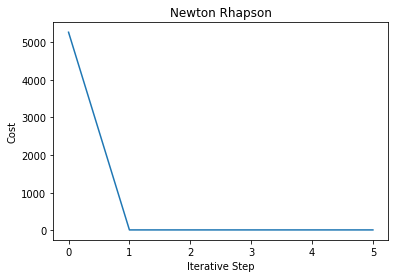

In [18]:
plt.plot(J['iterative_step'], J['cost'])
plt.title('Newton Rhapson') 
plt.xlabel('Iterative Step') 
plt.ylabel('Cost') 

In [19]:
print(Beta)

[[ 1.14896043]
 [ 0.50107481]
 [ 0.82878689]
 [-0.32210351]
 [ 1.00961511]
 [ 0.29553946]]


Let's compare this solution to that provided by the OLS model provided in the "statsmodels" package

In [20]:
## built in package
results = sm.ols(formula="S_Length ~ S_Width + P_Length + P_Width + Species_setosa + Species_versicolor", data=df).fit()
print(results.params)

Intercept             1.148960
S_Width               0.501075
P_Length              0.828787
P_Width              -0.322104
Species_setosa        1.009615
Species_versicolor    0.295539
dtype: float64
